# Proyecto 1 del curso de Machine Learning
## Presentado por Daniel Mateo Guatibonza [201611360] y Sofía Gutiérrez R [201612121]

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, zipfile, warnings, types, pathlib
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir = pathlib.Path("./DataNous/Caso_Facil")
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
image_count = len(list(data_dir.glob('*/*.png')))

12906

In [27]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
NB_CLASSES = len(CLASS_NAMES)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 12906 images belonging to 2 classes.


In [40]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

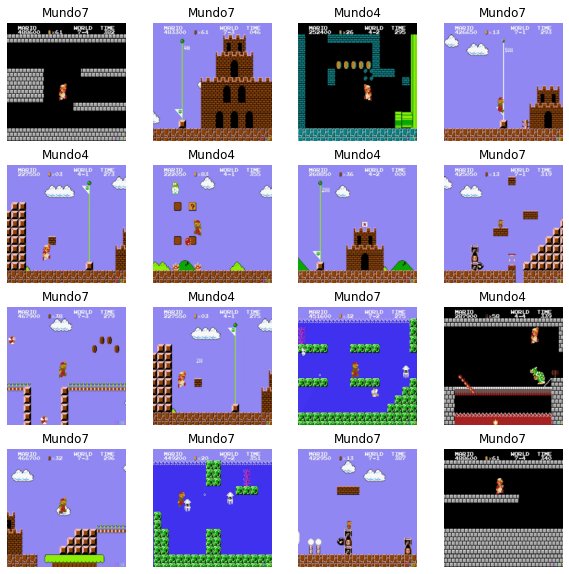

In [41]:
image_batch, label_batch = next(data_gen)
show_batch(image_batch, label_batch)

In [31]:
ds_mario = tf.data.Dataset.from_generator(lambda: data_gen,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3],
                                    [BATCH_SIZE, NB_CLASSES]))

<DatasetV1Adapter shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float32)>


In [39]:
train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)

train_dataset = ds_mario.take(train_size)
test_dataset = ds_mario.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

<DatasetV1Adapter shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float32)>

In [45]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 8s 1us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
________________

In [ ]:
from tensorflow.keras.utils import to_categorical

#Cambiar!!
nb_classes = 10
batch_size = 128

#Cargar Datos
(x_train, y_train),(x_test, y_test) = 
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

In [ ]:
input_shape = x_train[0].shape  + (1,)
input_shape
#Debería ser 256x256

# Red Neuronal

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization

In [47]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=IMG_SHAPE))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(64, (3, 3), input_shape=IMG_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(128, (3,3), input_shape=IMG_SHAPE))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(rate=0.5))
    
model.add(Dense(32, activation='relu'))
    

model.add(Dense(NB_CLASSES))

# Cambiar!!!
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.fit(train_dataset)